Epoch 1: Train Loss = 323.4754, Val Loss = 361.6559, Dice = 1.0508, Val Pixel Error = 16.4098
Epoch 2: Train Loss = 348.0433, Val Loss = 334.1248, Dice = -19.3461, Val Pixel Error = 15.8970
Epoch 3: Train Loss = 348.3098, Val Loss = 321.2381, Dice = 0.4595, Val Pixel Error = 15.2080
Epoch 4: Train Loss = 345.6279, Val Loss = 320.8707, Dice = 1.1127, Val Pixel Error = 15.2707
Epoch 5: Train Loss = 333.3541, Val Loss = 354.1420, Dice = -0.3078, Val Pixel Error = 16.4318
Epoch 6: Train Loss = 342.8205, Val Loss = 340.6803, Dice = 1.4877, Val Pixel Error = 16.0060
Epoch 7: Train Loss = 351.5211, Val Loss = 324.4592, Dice = 1.6391, Val Pixel Error = 15.4248
Epoch 8: Train Loss = 341.1352, Val Loss = 342.9571, Dice = -1.0463, Val Pixel Error = 16.1250
Epoch 9: Train Loss = 341.6700, Val Loss = 336.7180, Dice = 10.3560, Val Pixel Error = 15.6988
Epoch 10: Train Loss = 331.7540, Val Loss = 285.4367, Dice = -27.0921, Val Pixel Error = 14.9894
Epoch 11: Train Loss = 327.2576, Val Loss = 337.0847

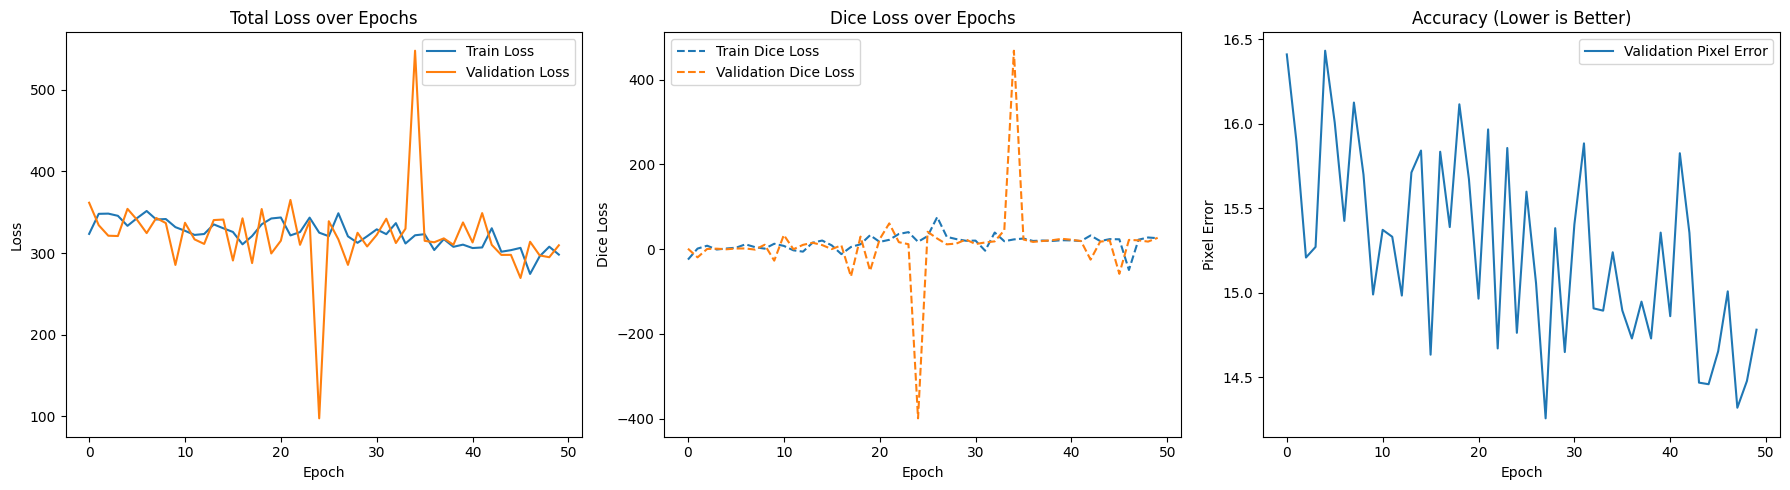

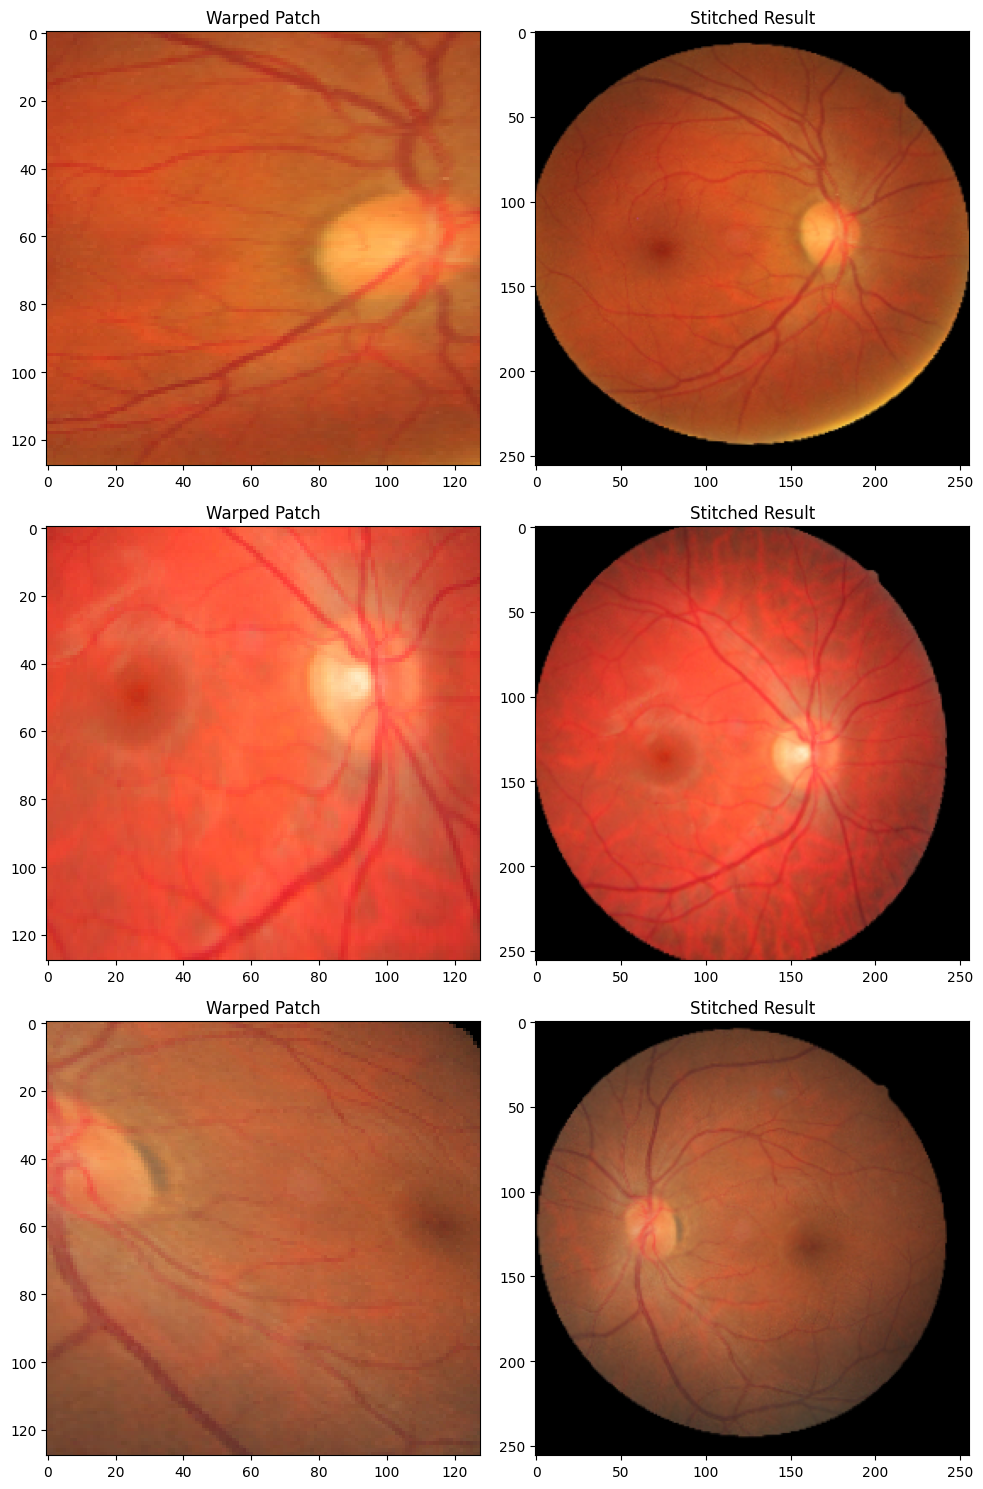

In [8]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATCH_SIZE = 128
PERTURBATION = 32

# Dataset class
class HomographyDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
                            if f.endswith(('.jpg', '.png', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        patch, warped_patch, _, offsets = generate_pair(img)
        if self.transform:
            patch = self.transform(patch)
            warped_patch = self.transform(warped_patch)
        pair = torch.cat([patch, warped_patch], dim=0)
        return pair, torch.tensor(offsets, dtype=torch.float32)

# Homography pair generation
def generate_pair(img):
    h, w = img.shape[:2]
    top_left = np.array([[(w - PATCH_SIZE) // 2, (h - PATCH_SIZE) // 2]])
    pts1 = np.array([
        top_left[0],
        top_left[0] + [PATCH_SIZE, 0],
        top_left[0] + [PATCH_SIZE, PATCH_SIZE],
        top_left[0] + [0, PATCH_SIZE]
    ], dtype=np.float32)

    offsets = np.random.uniform(-PERTURBATION, PERTURBATION, (4, 2)).astype(np.float32)
    pts2 = pts1 + offsets
    H = cv2.getPerspectiveTransform(pts1, pts2)
    warped = cv2.warpPerspective(img, H, (w, h))
    pts1_int = np.round(pts1).astype(int)
    patch = img[pts1_int[0][1]:pts1_int[2][1], pts1_int[0][0]:pts1_int[1][0]]
    warped_patch = warped[pts1_int[0][1]:pts1_int[2][1], pts1_int[0][0]:pts1_int[1][0]]
    return patch, warped_patch, H, offsets.flatten()

# Homography model
class HomographyModel(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(weights=None)
        resnet.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        self.head = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 8)
        )

    def forward(self, x):
        features = self.encoder(x)
        return self.head(features)

# Loss functions
def dice_loss(pred, target, epsilon=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)

def combined_loss(pred, target):
    mse = F.mse_loss(pred, target)
    dice = dice_loss(pred, target)
    return mse + 0.5 * dice

# Accuracy metric
def average_pixel_error(pred_offsets, gt_offsets):
    return F.l1_loss(pred_offsets, gt_offsets).item()

def apply_homography(image, offsets):
    h, w = image.shape[:2]
    base_pts = np.array([[0, 0], [PATCH_SIZE, 0], [PATCH_SIZE, PATCH_SIZE], [0, PATCH_SIZE]], dtype=np.float32)
    perturbed_pts = base_pts + offsets
    H = cv2.getPerspectiveTransform(base_pts, perturbed_pts)
    return cv2.warpPerspective(image, H, (w, h))

def visualize_stitching(model, dataset, num_samples=3):
    model.eval()
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

    for i in range(num_samples):
        img = cv2.imread(dataset.image_paths[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        patch, warped_patch, _, gt_offsets = generate_pair(img)

        input_tensor = torch.cat([
            transform(patch),
            transform(warped_patch)
        ]).unsqueeze(0).to(device)

        with torch.no_grad():
            pred_offsets = model(input_tensor).cpu().numpy().reshape(4, 2)

        stitched = apply_homography(img, pred_offsets)
        axs[i, 0].imshow(warped_patch)
        axs[i, 0].set_title("Warped Patch")
        axs[i, 1].imshow(stitched)
        axs[i, 1].set_title("Stitched Result")

    plt.tight_layout()
    plt.savefig("stitched_samples.png")
    plt.show()

# --- TRAINING FUNCTION WITH DICE METRICS ---
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=50, patience=5):
    train_losses, val_losses, accs = [], [], []
    train_dice_losses, val_dice_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_wts = None

    for epoch in range(epochs):
        model.train()
        total_loss, total_acc, total_dice = 0, 0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            dice = dice_loss(pred, y)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()
            total_acc += average_pixel_error(pred, y)
            total_dice += dice.item()

        avg_train_loss = total_loss / len(train_loader)
        avg_train_acc = total_acc / len(train_loader)
        avg_train_dice = total_dice / len(train_loader)

        # --- VALIDATION ---
        model.eval()
        val_loss, val_acc, val_dice = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                val_loss += criterion(pred, y).item()
                val_acc += average_pixel_error(pred, y)
                val_dice += dice_loss(pred, y).item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        accs.append(avg_val_acc)
        train_dice_losses.append(avg_train_dice)
        val_dice_losses.append(avg_val_dice)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Dice = {avg_val_dice:.4f}, Val Pixel Error = {avg_val_acc:.4f}")

    # --- PLOTTING ---
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Total Loss over Epochs")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(train_dice_losses, label="Train Dice Loss", linestyle='--')
    plt.plot(val_dice_losses, label="Validation Dice Loss", linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Dice Loss")
    plt.title("Dice Loss over Epochs")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(accs, label="Validation Pixel Error")
    plt.xlabel("Epoch")
    plt.ylabel("Pixel Error")
    plt.title("Accuracy (Lower is Better)")
    plt.legend()

    plt.tight_layout()
    plt.savefig("training_metrics.png")
    plt.show()

# Main script
if __name__ == '__main__':
    transform = T.Compose([
        T.ToTensor(),
        T.Resize((128, 128))
    ])

    dataset = HomographyDataset("/kaggle/input/fundus-image-registration/FIRE/Images", transform=transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    model = HomographyModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_model(model, train_loader, val_loader, optimizer, combined_loss, epochs=50)
    torch.save(model.state_dict(), "homography_resnet_best.pth")
    visualize_stitching(model, dataset)


Epoch 1: Loss = 346.6480, Dice = 0.9187, Pixel Error = 16.1259
Epoch 2: Loss = 343.6085, Dice = 5.4273, Pixel Error = 16.0753
Epoch 3: Loss = 351.7463, Dice = 7.3008, Pixel Error = 16.1857
Epoch 4: Loss = 335.3663, Dice = 1.3659, Pixel Error = 15.7990
Epoch 5: Loss = 335.8145, Dice = 0.1751, Pixel Error = 15.8134
Epoch 6: Loss = 344.9865, Dice = 4.6987, Pixel Error = 16.0373
Epoch 7: Loss = 327.5356, Dice = -9.8154, Pixel Error = 15.7988
Epoch 8: Loss = 333.4879, Dice = 2.3861, Pixel Error = 15.7590
Epoch 9: Loss = 333.7491, Dice = 2.0249, Pixel Error = 15.7436
Epoch 10: Loss = 331.3471, Dice = -0.8018, Pixel Error = 15.8222
Epoch 11: Loss = 343.3142, Dice = 3.9196, Pixel Error = 16.0102
Epoch 12: Loss = 341.7446, Dice = 16.0541, Pixel Error = 15.8176
Epoch 13: Loss = 341.1267, Dice = 4.0179, Pixel Error = 15.8810
Epoch 14: Loss = 349.6898, Dice = 1.7374, Pixel Error = 16.2505
Epoch 15: Loss = 337.7726, Dice = 3.2104, Pixel Error = 15.7674
Epoch 16: Loss = 341.2479, Dice = 2.6504, Pixe

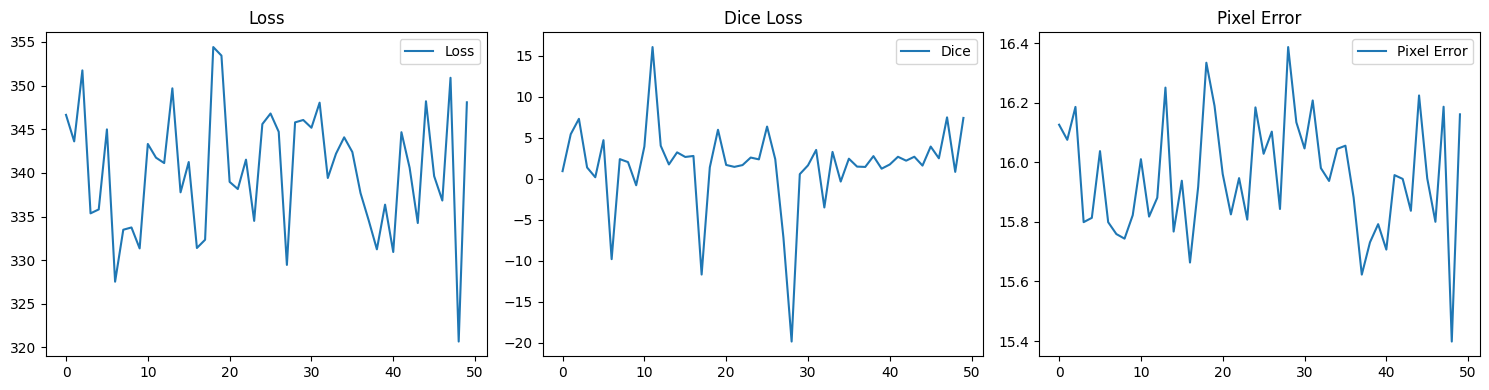

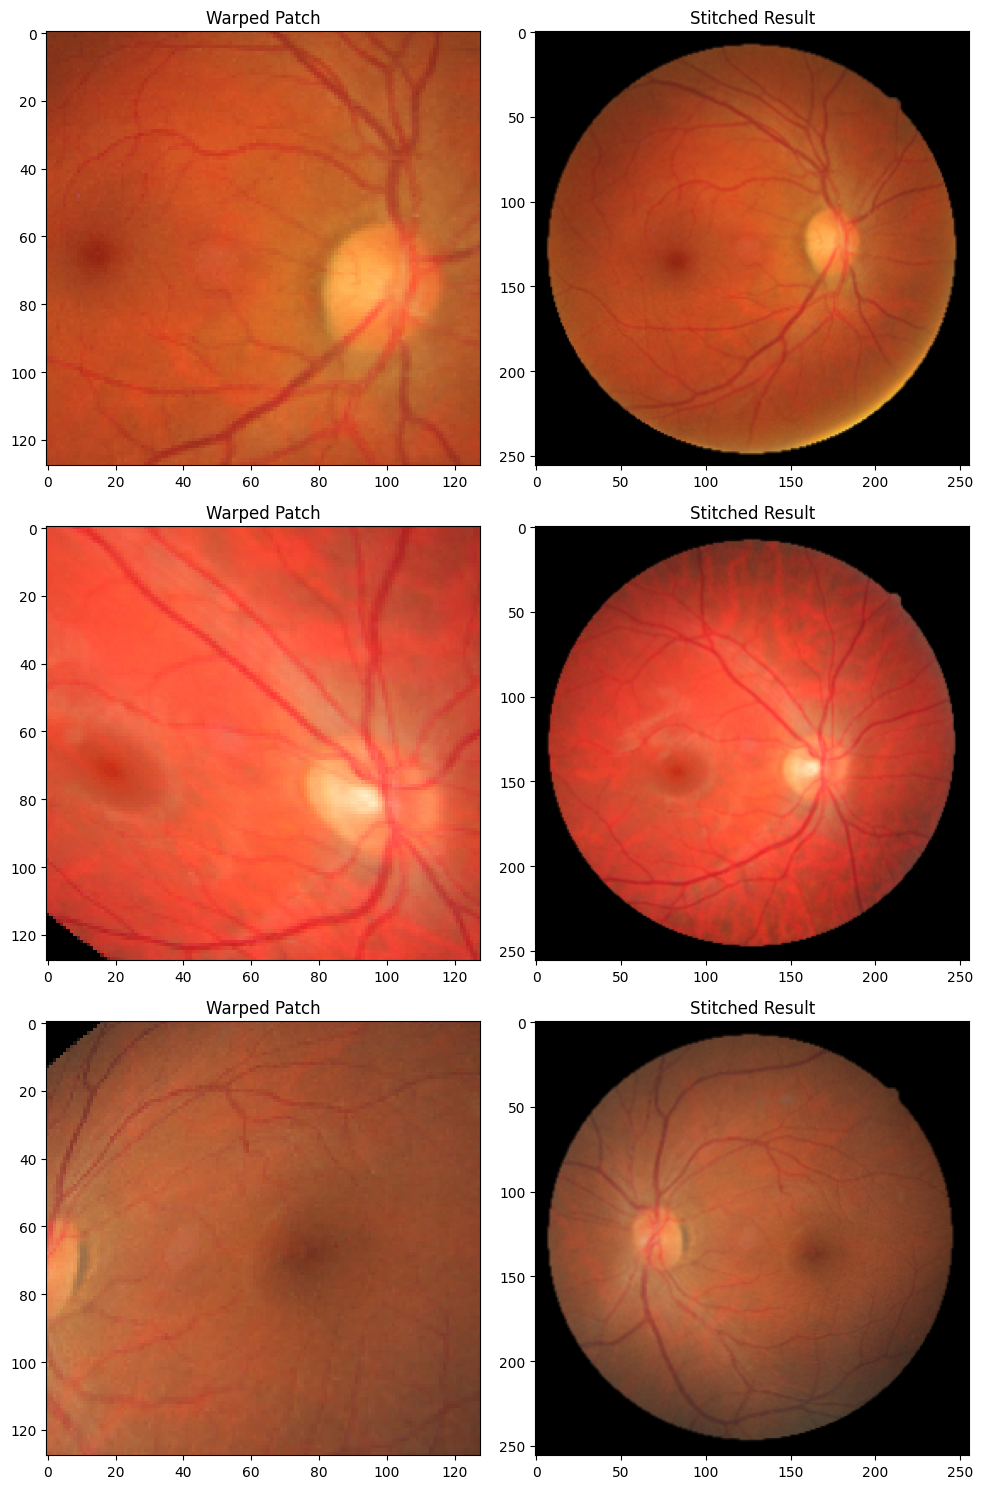

In [1]:
# === Full Dataset Training - No Validation ===

import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATCH_SIZE = 128
PERTURBATION = 32

# Dataset class
class HomographyDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
                            if f.endswith(('.jpg', '.png', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        patch, warped_patch, _, offsets = generate_pair(img)
        if self.transform:
            patch = self.transform(patch)
            warped_patch = self.transform(warped_patch)
        pair = torch.cat([patch, warped_patch], dim=0)
        return pair, torch.tensor(offsets, dtype=torch.float32)

# Homography pair generation
def generate_pair(img):
    h, w = img.shape[:2]
    top_left = np.array([[(w - PATCH_SIZE) // 2, (h - PATCH_SIZE) // 2]])
    pts1 = np.array([
        top_left[0],
        top_left[0] + [PATCH_SIZE, 0],
        top_left[0] + [PATCH_SIZE, PATCH_SIZE],
        top_left[0] + [0, PATCH_SIZE]
    ], dtype=np.float32)

    offsets = np.random.uniform(-PERTURBATION, PERTURBATION, (4, 2)).astype(np.float32)
    pts2 = pts1 + offsets
    H = cv2.getPerspectiveTransform(pts1, pts2)
    warped = cv2.warpPerspective(img, H, (w, h))
    pts1_int = np.round(pts1).astype(int)
    patch = img[pts1_int[0][1]:pts1_int[2][1], pts1_int[0][0]:pts1_int[1][0]]
    warped_patch = warped[pts1_int[0][1]:pts1_int[2][1], pts1_int[0][0]:pts1_int[1][0]]
    return patch, warped_patch, H, offsets.flatten()

# Model
class HomographyModel(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(weights=None)
        resnet.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        self.head = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 8)
        )

    def forward(self, x):
        features = self.encoder(x)
        return self.head(features)

# Losses
def dice_loss(pred, target, epsilon=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)

def combined_loss(pred, target):
    mse = F.mse_loss(pred, target)
    dice = dice_loss(pred, target)
    return mse + 0.5 * dice, dice

def average_pixel_error(pred_offsets, gt_offsets):
    return F.l1_loss(pred_offsets, gt_offsets).item()

# Training (no validation)
def train_model(model, loader, optimizer, criterion, epochs=50):
    model.to(device)
    all_losses, all_dices, all_errors = [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss, total_dice, total_error = 0, 0, 0

        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss, dice = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_dice += dice.item()
            total_error += average_pixel_error(pred, y)

        avg_loss = total_loss / len(loader)
        avg_dice = total_dice / len(loader)
        avg_error = total_error / len(loader)

        all_losses.append(avg_loss)
        all_dices.append(avg_dice)
        all_errors.append(avg_error)

        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Dice = {avg_dice:.4f}, Pixel Error = {avg_error:.4f}")

    # Plotting
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(all_losses, label="Loss")
    plt.legend(); plt.title("Loss")

    plt.subplot(1, 3, 2)
    plt.plot(all_dices, label="Dice")
    plt.legend(); plt.title("Dice Loss")

    plt.subplot(1, 3, 3)
    plt.plot(all_errors, label="Pixel Error")
    plt.legend(); plt.title("Pixel Error")

    plt.tight_layout()
    plt.savefig("training_metrics.png")
    plt.show()

# Visualization
def visualize_stitching(model, dataset, num_samples=3):
    model.eval()
    transform = T.ToTensor()
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

    for i in range(num_samples):
        img = cv2.imread(dataset.image_paths[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        patch, warped_patch, _, _ = generate_pair(img)

        input_tensor = torch.cat([transform(patch), transform(warped_patch)], dim=0).unsqueeze(0).to(device)

        with torch.no_grad():
            pred_offsets = model(input_tensor).cpu().numpy().reshape(4, 2)

        stitched = apply_homography(img, pred_offsets)
        axs[i, 0].imshow(warped_patch)
        axs[i, 0].set_title("Warped Patch")
        axs[i, 1].imshow(stitched)
        axs[i, 1].set_title("Stitched Result")

    plt.tight_layout()
    plt.savefig("stitched_samples.png")
    plt.show()

def apply_homography(image, offsets):
    h, w = image.shape[:2]
    base_pts = np.array([[0, 0], [PATCH_SIZE, 0], [PATCH_SIZE, PATCH_SIZE], [0, PATCH_SIZE]], dtype=np.float32)
    perturbed_pts = base_pts + offsets
    H = cv2.getPerspectiveTransform(base_pts, perturbed_pts)
    return cv2.warpPerspective(image, H, (w, h))

# === MAIN ===
if __name__ == '__main__':
    dataset = HomographyDataset(image_folder="/kaggle/input/fundus-image-registration/FIRE/Images", transform=T.ToTensor())
    loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

    model = HomographyModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_model(model, loader, optimizer, combined_loss, epochs=50)

    torch.save(model.state_dict(), "homography_resnet_best.pth")
    visualize_stitching(model, dataset)


Epoch 1: Loss = 350.2687, Pixel Error = 16.2876
Epoch 2: Loss = 336.5260, Pixel Error = 15.8265
Epoch 3: Loss = 333.6497, Pixel Error = 15.7898
Epoch 4: Loss = 349.6343, Pixel Error = 16.2175
Epoch 5: Loss = 340.1979, Pixel Error = 15.9047
Epoch 6: Loss = 349.4083, Pixel Error = 16.2462
Epoch 7: Loss = 325.7552, Pixel Error = 15.6271
Epoch 8: Loss = 329.4448, Pixel Error = 15.6970
Epoch 9: Loss = 330.3092, Pixel Error = 15.7291
Epoch 10: Loss = 329.3514, Pixel Error = 15.7721
Epoch 11: Loss = 307.6930, Pixel Error = 15.0758
Epoch 12: Loss = 319.7464, Pixel Error = 15.4370
Epoch 13: Loss = 315.4623, Pixel Error = 15.4238
Epoch 14: Loss = 312.8395, Pixel Error = 15.3388
Epoch 15: Loss = 310.0512, Pixel Error = 15.1854
Epoch 16: Loss = 319.8901, Pixel Error = 15.5189
Epoch 17: Loss = 309.7808, Pixel Error = 15.2074
Epoch 18: Loss = 305.0559, Pixel Error = 15.0454
Epoch 19: Loss = 310.3682, Pixel Error = 15.3326
Epoch 20: Loss = 302.3643, Pixel Error = 15.0611
Epoch 21: Loss = 307.8474, Pi

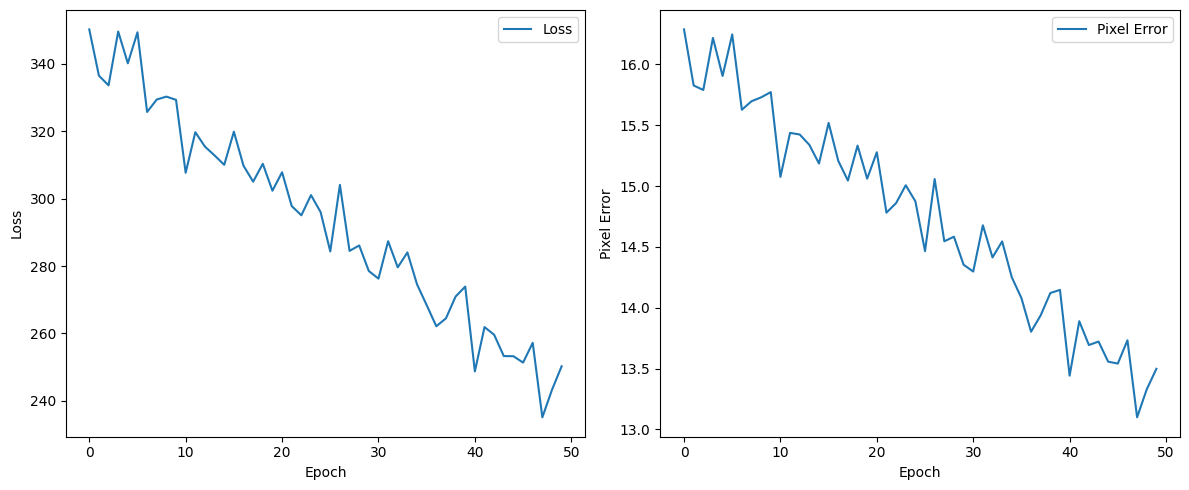

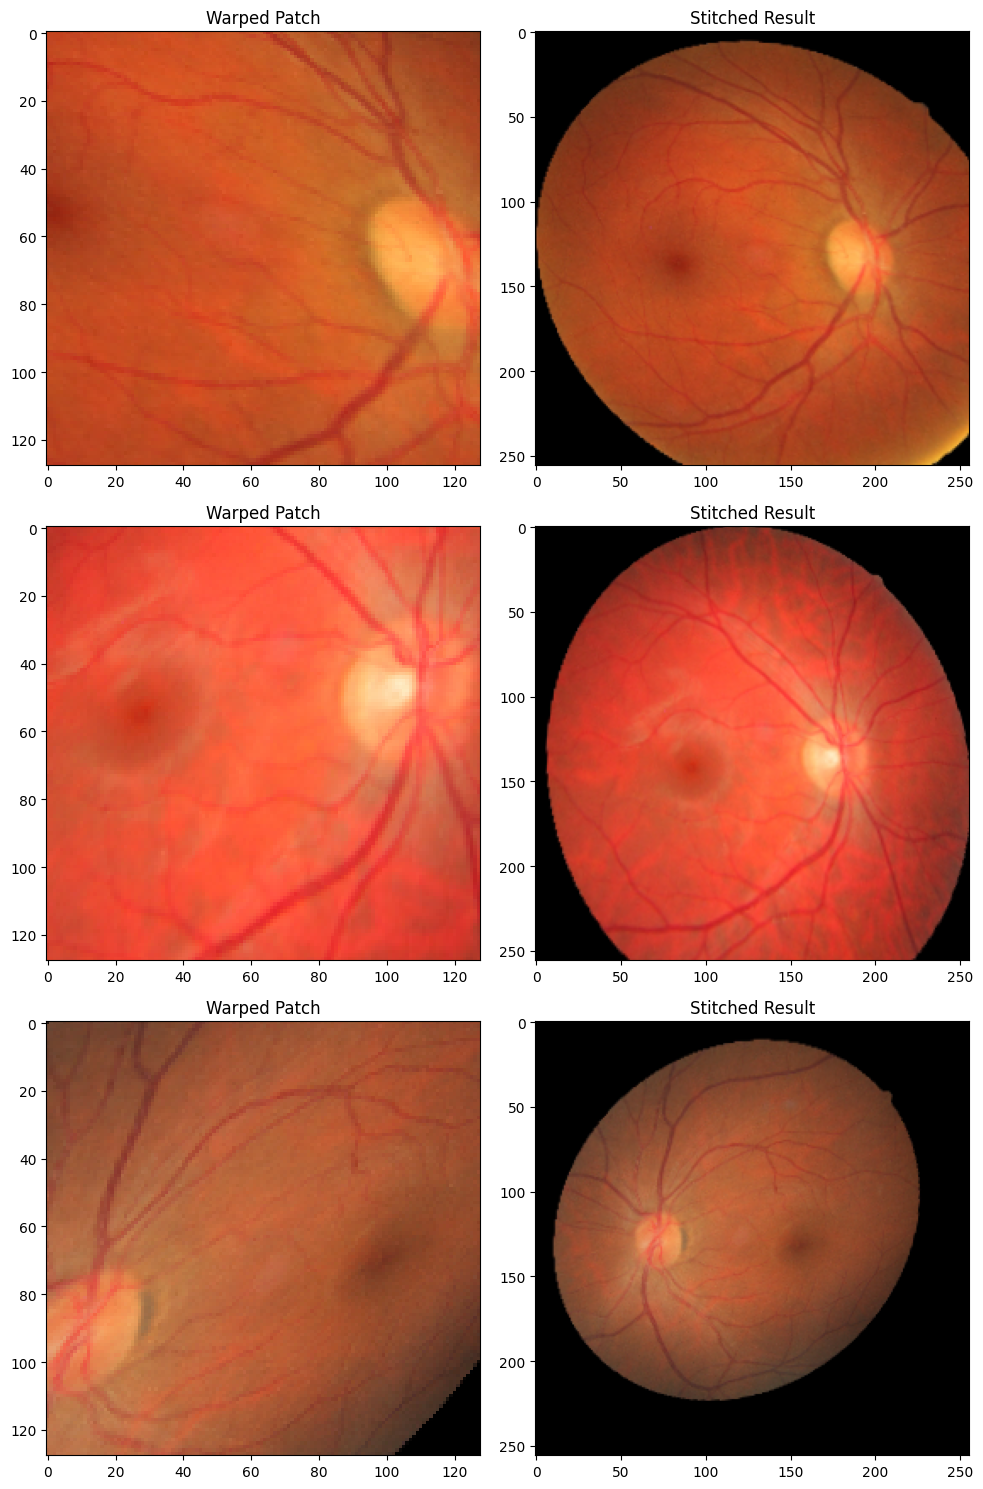

In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATCH_SIZE = 128
PERTURBATION = 32

# Dataset class
class HomographyDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
                            if f.endswith(('.jpg', '.png', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        patch, warped_patch, _, offsets = generate_pair(img)
        if self.transform:
            patch = self.transform(patch)
            warped_patch = self.transform(warped_patch)
        pair = torch.cat([patch, warped_patch], dim=0)
        return pair, torch.tensor(offsets, dtype=torch.float32)

# Homography pair generation
def generate_pair(img):
    h, w = img.shape[:2]
    top_left = np.array([[(w - PATCH_SIZE) // 2, (h - PATCH_SIZE) // 2]])
    pts1 = np.array([
        top_left[0],
        top_left[0] + [PATCH_SIZE, 0],
        top_left[0] + [PATCH_SIZE, PATCH_SIZE],
        top_left[0] + [0, PATCH_SIZE]
    ], dtype=np.float32)

    offsets = np.random.uniform(-PERTURBATION, PERTURBATION, (4, 2)).astype(np.float32)
    pts2 = pts1 + offsets
    H = cv2.getPerspectiveTransform(pts1, pts2)
    warped = cv2.warpPerspective(img, H, (w, h))
    pts1_int = np.round(pts1).astype(int)
    patch = img[pts1_int[0][1]:pts1_int[2][1], pts1_int[0][0]:pts1_int[1][0]]
    warped_patch = warped[pts1_int[0][1]:pts1_int[2][1], pts1_int[0][0]:pts1_int[1][0]]
    return patch, warped_patch, H, offsets.flatten()

# Homography model
class HomographyModel(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(weights=None)
        resnet.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        self.head = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 8)
        )

    def forward(self, x):
        features = self.encoder(x)
        return self.head(features)

# Accuracy metric
def average_pixel_error(pred_offsets, gt_offsets):
    return F.l1_loss(pred_offsets, gt_offsets).item()

def apply_homography(image, offsets):
    h, w = image.shape[:2]
    base_pts = np.array([[0, 0], [PATCH_SIZE, 0], [PATCH_SIZE, PATCH_SIZE], [0, PATCH_SIZE]], dtype=np.float32)
    perturbed_pts = base_pts + offsets
    H = cv2.getPerspectiveTransform(base_pts, perturbed_pts)
    return cv2.warpPerspective(image, H, (w, h))

def visualize_stitching(model, dataset, transform, num_samples=3):
    model.eval()
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

    for i in range(num_samples):
        img = cv2.imread(dataset.image_paths[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        patch, warped_patch, _, gt_offsets = generate_pair(img)

        input_tensor = torch.cat([
            transform(patch),
            transform(warped_patch)
        ]).unsqueeze(0).to(device)

        with torch.no_grad():
            pred_offsets = model(input_tensor).cpu().numpy().reshape(4, 2)

        stitched = apply_homography(img, pred_offsets)
        axs[i, 0].imshow(warped_patch)
        axs[i, 0].set_title("Warped Patch")
        axs[i, 1].imshow(stitched)
        axs[i, 1].set_title("Stitched Result")

    plt.tight_layout()
    plt.savefig("stitched_samples.png")
    plt.show()

# Training function (no validation)
def train_model(model, loader, optimizer, criterion, epochs=50):
    losses, pixel_errors = [], []
    model.train()

    for epoch in range(epochs):
        total_loss, total_error = 0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()
            total_error += average_pixel_error(pred, y)

        avg_loss = total_loss / len(loader)
        avg_error = total_error / len(loader)

        losses.append(avg_loss)
        pixel_errors.append(avg_error)

        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Pixel Error = {avg_error:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(pixel_errors, label='Pixel Error')
    plt.xlabel('Epoch')
    plt.ylabel('Pixel Error')
    plt.legend()

    plt.tight_layout()
    plt.savefig("training_metrics.png")
    plt.show()

# Main
if __name__ == '__main__':
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])

    dataset = HomographyDataset("/kaggle/input/fundus-image-registration/FIRE/Images", transform=transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

    model = HomographyModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = F.mse_loss

    train_model(model, loader, optimizer, criterion, epochs=50)

    torch.save(model.state_dict(), "/kaggle/working/homography_resnet_best.pth")
    visualize_stitching(model, dataset, transform)


Epoch 1: Loss = 339.9392, Dice = 0.7100, Pixel Error = 15.9786
Epoch 2: Loss = 339.5294, Dice = -2.8620, Pixel Error = 16.0242
Epoch 3: Loss = 340.4093, Dice = 7.0340, Pixel Error = 15.9055
Epoch 4: Loss = 338.0813, Dice = -0.2988, Pixel Error = 15.9103
Epoch 5: Loss = 335.5078, Dice = 0.5897, Pixel Error = 15.8801
Epoch 6: Loss = 297.7464, Dice = -41.7817, Pixel Error = 15.3956
Epoch 7: Loss = 319.5952, Dice = -14.1497, Pixel Error = 15.6043
Epoch 8: Loss = 326.1765, Dice = 5.6584, Pixel Error = 15.5882
Epoch 9: Loss = 289.4944, Dice = -86.4675, Pixel Error = 15.8540
Epoch 10: Loss = 323.7224, Dice = 3.1654, Pixel Error = 15.5497
Epoch 11: Loss = 323.4966, Dice = -0.6503, Pixel Error = 15.5570
Epoch 12: Loss = 333.9416, Dice = 34.9261, Pixel Error = 15.3401
Epoch 13: Loss = 327.6042, Dice = 18.5978, Pixel Error = 15.4745
Epoch 14: Loss = 356.9764, Dice = 115.1758, Pixel Error = 14.8145
Epoch 15: Loss = 305.9916, Dice = 17.9761, Pixel Error = 14.6996
Epoch 16: Loss = 227.5597, Dice = -

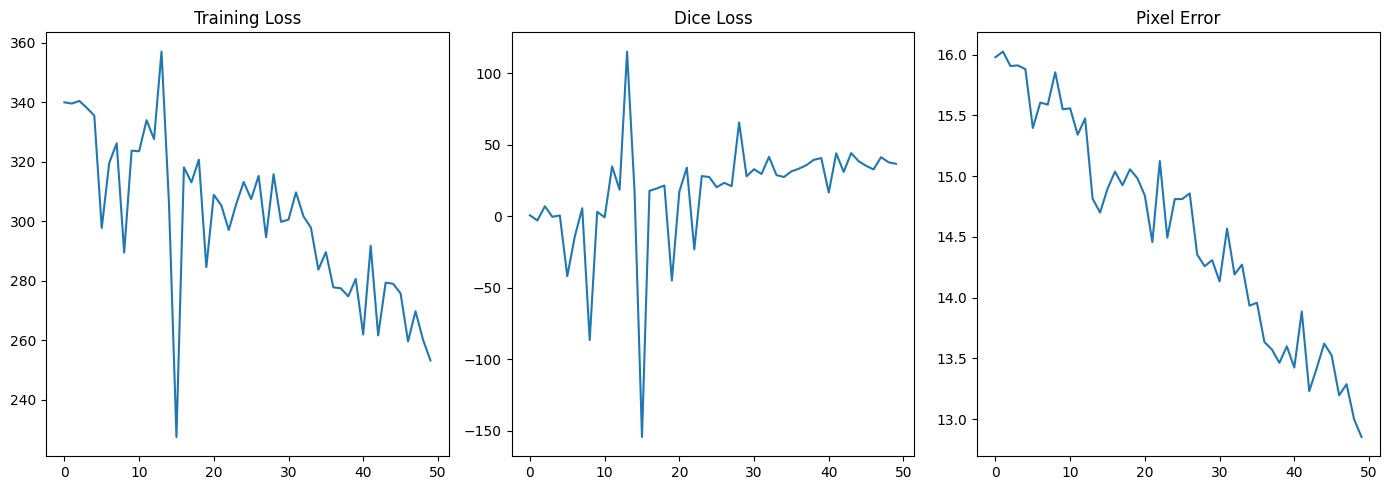

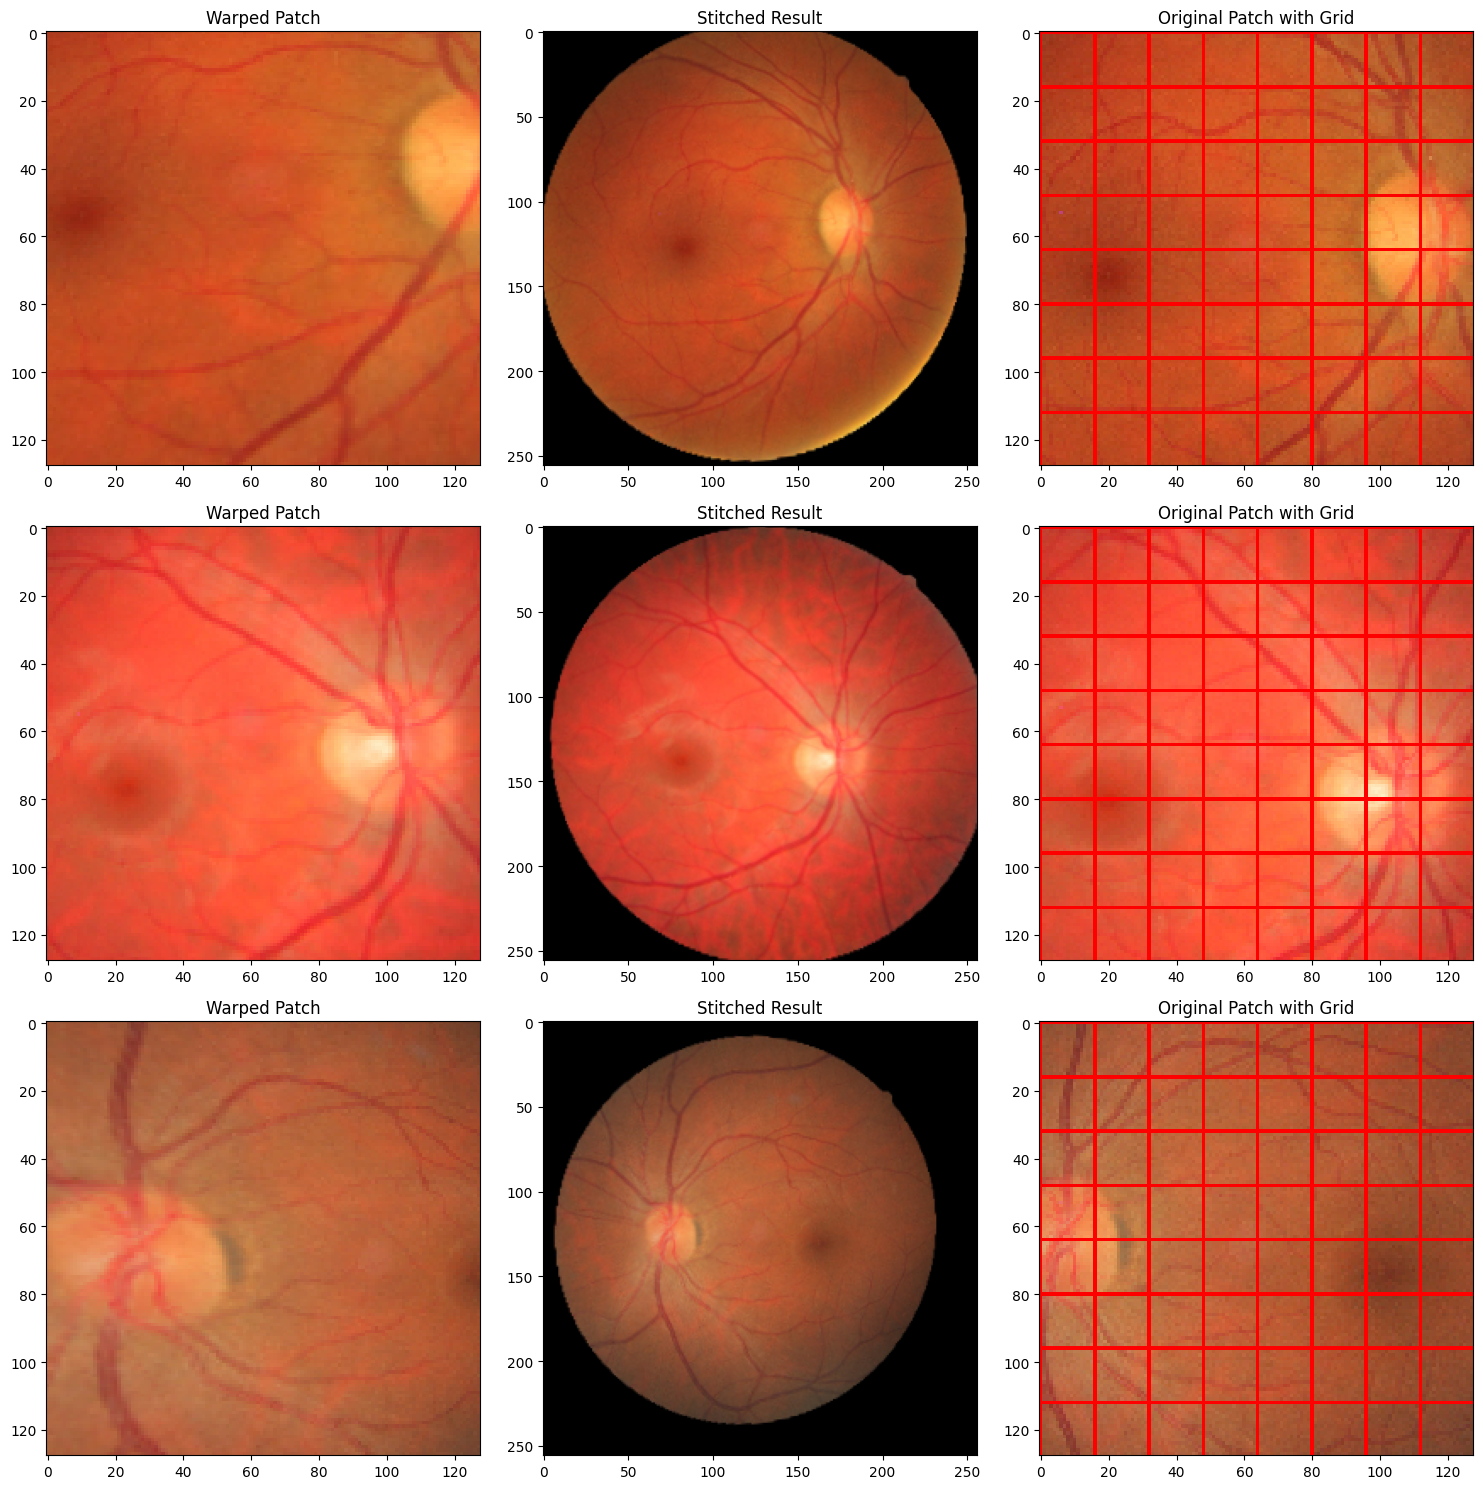

In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib import animation

# Device and constants
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATCH_SIZE = 128
PERTURBATION = 32

# Dataset class
class HomographyDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
                            if f.endswith(('.jpg', '.png', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        patch, warped_patch, _, offsets = generate_pair(img)
        if self.transform:
            patch = self.transform(patch)
            warped_patch = self.transform(warped_patch)
        pair = torch.cat([patch, warped_patch], dim=0)
        return pair, offsets

# Homography pair generation
def generate_pair(img):
    h, w = img.shape[:2]
    top_left = np.array([[(w - PATCH_SIZE) // 2, (h - PATCH_SIZE) // 2]])
    pts1 = np.array([
        top_left[0],
        top_left[0] + [PATCH_SIZE, 0],
        top_left[0] + [PATCH_SIZE, PATCH_SIZE],
        top_left[0] + [0, PATCH_SIZE]
    ], dtype=np.float32)

    offsets = np.random.uniform(-PERTURBATION, PERTURBATION, (4, 2)).astype(np.float32)
    pts2 = pts1 + offsets
    H = cv2.getPerspectiveTransform(pts1, pts2)
    warped = cv2.warpPerspective(img, H, (w, h))
    pts1_int = np.round(pts1).astype(int)
    patch = img[pts1_int[0][1]:pts1_int[2][1], pts1_int[0][0]:pts1_int[1][0]]
    warped_patch = warped[pts1_int[0][1]:pts1_int[2][1], pts1_int[0][0]:pts1_int[1][0]]
    return patch, warped_patch, H, offsets.flatten()

# Homography model
class HomographyModel(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(weights=None)
        resnet.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        self.head = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 8)
        )

    def forward(self, x):
        features = self.encoder(x)
        return self.head(features)

# Helper functions
def apply_homography(image, offsets):
    h, w = image.shape[:2]
    base_pts = np.array([[0, 0], [PATCH_SIZE, 0], [PATCH_SIZE, PATCH_SIZE], [0, PATCH_SIZE]], dtype=np.float32)
    perturbed_pts = base_pts + offsets.reshape(4, 2)
    H = cv2.getPerspectiveTransform(base_pts, perturbed_pts)
    return cv2.warpPerspective(image, H, (w, h))

def dice_loss(pred, target, epsilon=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)

def combined_loss(pred, target):
    mse = F.mse_loss(pred, target)
    dice = dice_loss(pred, target)
    return mse + 0.5 * dice

def average_pixel_error(pred_offsets, gt_offsets):
    return F.l1_loss(pred_offsets, gt_offsets).item()

def visualize_stitching(model, dataset, num_samples=3):
    model.eval()
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    ims = []
    for i in range(num_samples):
        img = cv2.imread(dataset.image_paths[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        patch, warped_patch, _, gt_offsets = generate_pair(img)

        transform = T.ToTensor()
        input_tensor = torch.cat([
            transform(patch),
            transform(warped_patch)
        ]).unsqueeze(0).to(device)

        with torch.no_grad():
            pred_offsets = model(input_tensor).cpu().numpy().reshape(4, 2)

        stitched = apply_homography(img, pred_offsets)
        grid_patch = patch.copy()
        for j in range(0, PATCH_SIZE, 16):
            cv2.line(grid_patch, (j, 0), (j, PATCH_SIZE), (255, 0, 0), 1)
            cv2.line(grid_patch, (0, j), (PATCH_SIZE, j), (255, 0, 0), 1)

        axs[i, 0].imshow(warped_patch)
        axs[i, 0].set_title("Warped Patch")
        axs[i, 1].imshow(stitched)
        axs[i, 1].set_title("Stitched Result")
        axs[i, 2].imshow(grid_patch)
        axs[i, 2].set_title("Original Patch with Grid")

        ims.append([axs[i, j].imshow(axs[i, j].images[0].get_array(), animated=True) for j in range(3)])

    plt.tight_layout()
    ani = animation.ArtistAnimation(fig, ims, interval=1000, blit=True)
    ani.save("stitched_animation.gif", writer='pillow')
    plt.show()

# Training function (no validation)
def train_full(model, loader, optimizer, criterion, epochs=50):
    losses, errors, dices = [], [], []
    model.train()

    for epoch in range(epochs):
        epoch_loss, epoch_error, epoch_dice = 0, 0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            epoch_loss += loss.item()
            epoch_error += average_pixel_error(pred, y)
            epoch_dice += dice_loss(pred, y).item()

        avg_loss = epoch_loss / len(loader)
        avg_error = epoch_error / len(loader)
        avg_dice = epoch_dice / len(loader)

        losses.append(avg_loss)
        errors.append(avg_error)
        dices.append(avg_dice)

        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Dice = {avg_dice:.4f}, Pixel Error = {avg_error:.4f}")

    # Plot training metrics
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 3, 1)
    plt.plot(losses)
    plt.title("Training Loss")

    plt.subplot(1, 3, 2)
    plt.plot(dices)
    plt.title("Dice Loss")

    plt.subplot(1, 3, 3)
    plt.plot(errors)
    plt.title("Pixel Error")

    plt.tight_layout()
    plt.savefig("training_metrics.png")
    plt.show()

# Main
if __name__ == '__main__':
    image_folder = "/kaggle/input/fundus-image-registration/FIRE/Images"  # <- Update this path
    transform = T.ToTensor()
    dataset = HomographyDataset(image_folder, transform=transform)
    loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

    model = HomographyModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_full(model, loader, optimizer, combined_loss, epochs=50)
    torch.save(model.state_dict(), "homography_resnet_best.pth")

    visualize_stitching(model, dataset)

